# Quantum Computer lab 4

These lab exercises are **NOT** part of the assesment of the module, but they should be useful training for the coursework.

* Please run the code to make sure it works, then try the questions.
* The idea is to explore the influence on noise on circuits



## Background to quantum noise

*  Overview of quantum noise from Amazon  https://aws.amazon.com/blogs/quantum-computing/noise-in-quantum-computing/
*  Tutorial: Quantum Noise Characterization and Mitigation  https://volya.xyz/blog/qce2022/main.pdf
*  Tutorial on quantum noise characterization and mitigation  https://rustybamboo.github.io/qc-err-mitig/intro.html 

##  Installing pennylane on the University machines and your laptop

There are instructions on how to install pennylane on your computer at: https://pennylane.ai/install/

In the annaconda prompt or terminal on a Mac type 

pip install pennylane --upgrade

If you have spyder running you may need to restart spyder to access the library.

You will have to run this command everytime you work on a new PC in the lab.

There may be  additional complications with the University PCs,because of administrative rights. 







##  Classsical noise  (Coherent noise)

Examples taken from https://pennylane.ai/blog/2021/05/how-to-simulate-noise-with-pennylane

In [3]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

dev1 = qml.device("default.qubit", wires=1)

@qml.qnode(dev1)
def nonoise_circuit():
    rand_angle = 0.0
    # np.random.rand() uniformly samples from [0, 1)
    qml.RX(rand_angle, wires=0)
    return qml.expval(qml.PauliZ(0))



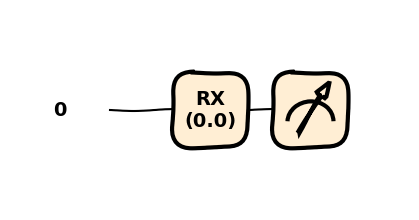

In [4]:
qnode = qml.QNode(nonoise_circuit, dev1)
qml.draw_mpl(qnode, decimals=1, style="sketch")()
plt.show()

In [5]:
print(nonoise_circuit())

1.0


expval takes the expectation value

$$  <0 | \sigma_z | 0 > = 1 $$

This agrees with the simulation

## Introduce some noise

One way to introduce noise is to add a random rotation to the circuit.

The definition of the Rx gate is from https://docs.pennylane.ai/en/stable/code/api/pennylane.RX.html

See the circuit below

RX(rand_angle) is the random noise.

$$
R_x(\phi) = e^{-i\phi\sigma_x/2} = \begin{bmatrix}
                \cos(\phi/2) & -i\sin(\phi/2) \\
                -i\sin(\phi/2) & \cos(\phi/2)
            \end{bmatrix}.
$$


In [6]:
import pennylane as qml
from pennylane import numpy as np

dev1 = qml.device("default.qubit", wires=1)

@qml.qnode(dev1)
def rot_circuit(prec):
    rand_angle = np.pi + prec*np.random.rand()
    # np.random.rand() uniformly samples from [0, 1)
    qml.RX(rand_angle, wires=0)
    return qml.expval(qml.PauliZ(0))

## evaluate the circuit 

In [7]:
print(rot_circuit(4))
print(rot_circuit(0.1))


0.8040674800074707
-0.9966972233402661


## add some quantum noise

The BitFlip operator randomly flips the qubit


In [9]:
dev2 = qml.device('default.mixed', wires=1)
@qml.qnode(dev2)
def bitflip_circuit(p):
    qml.BitFlip(p, wires=0)
    return qml.expval(qml.PauliZ(0))


In [10]:
for p in [ 0, 0.1 , 0.99] :
   print("Prob of flip ", p, bitflip_circuit(p))

Prob of flip  0 0.9999999999999998
Prob of flip  0.1 0.8
Prob of flip  0.99 -0.98


##  Quantum noise 

Examples taken from https://pennylane.ai/qml/demos/tutorial_noisy_circuits



In [11]:
import pennylane as qml
from jax import numpy as np
import jax

dev = qml.device('default.mixed', wires=2)

@qml.qnode(dev)
def circuit():
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))


print(f"QNode output = {circuit():.4f}")

QNode output = 1.0000


## Compute the density matrix

The density matrix is a critical object to evaluate quantum noise.

The circuit below creates the state from the input $ |00> $

$$
|\psi > = \frac{1}{\sqrt{2}} ( |00> + |11> )
$$


In [12]:
@qml.qnode(dev)
def density_matrix_circuit():
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    return qml.state()

matrix = density_matrix_circuit()
print(f"Output density matrix is = \n{np.real(matrix)}")

Output density matrix is = 
[[0.5 0.  0.  0.5]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.5 0.  0.  0.5]]


Question

Can you derive the density matrix from the state.
$$
|\psi > = \frac{1}{\sqrt{2}} ( |00> + |11> )
$$



## Quantum noise

Example from https://pennylane.ai/qml/demos/tutorial_noisy_circuits

In [13]:
import pennylane as qml

dev = qml.device('default.mixed', wires=2)

@qml.qnode(dev)
def bitflip_circuit(p):
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.BitFlip(p, wires=0)
    qml.BitFlip(p, wires=1)
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))


ps = [0.001, 0.01, 0.1, 0.2]
for p in ps:
    print(f"QNode output for bit flip probability {p} is {bitflip_circuit(p):.4f}")

QNode output for bit flip probability 0.001 is 0.9960
QNode output for bit flip probability 0.01 is 0.9604
QNode output for bit flip probability 0.1 is 0.6400
QNode output for bit flip probability 0.2 is 0.3600


The density matrix can be computed

In [15]:
import numpy as np
p = 0.2
print(f"Output state for bit flip probability {p} is \n{np.real(dev.state)}")

Output state for bit flip probability 0.2 is 
[[0.34 0.   0.   0.34]
 [0.   0.16 0.16 0.  ]
 [0.   0.16 0.16 0.  ]
 [0.34 0.   0.   0.34]]


QUESTION

Modify the above circuit to add one of the other noise 

* PhaseFlip, https://docs.pennylane.ai/en/stable/code/api/pennylane.PhaseFlip.html#pennylane.PhaseFlip
* AmplitudeDamping, https://docs.pennylane.ai/en/stable/code/api/pennylane.AmplitudeDamping.html#pennylane.AmplitudeDamping
* GeneralizedAmplitudeDamping, https://docs.pennylane.ai/en/stable/code/api/pennylane.GeneralizedAmplitudeDamping.html#pennylane.GeneralizedAmplitudeDamping
* PhaseDamping, https://docs.pennylane.ai/en/stable/code/api/pennylane.PhaseDamping.html#pennylane.PhaseDamping
* DepolarizingChannel, https://docs.pennylane.ai/en/stable/code/api/pennylane.DepolarizingChannel.html#pennylane.DepolarizingChannel




## Qiskit

Pennylane can also use the noise models from IBM's qiskit library

The library below needs to be installed

pip install pennylane-qiskit


In [16]:
#  https://discuss.pennylane.ai/t/qml-device-error-with-qiskit-aer/4556/6
# update from https://qiskit.github.io/qiskit-aer/tutorials/3_building_noise_models.html

from qiskit_ibm_runtime.fake_provider import FakeSantiago

In [17]:
import qiskit_aer
import qiskit_aer.noise 

In [18]:
import qiskit
#import qiskit.providers.aer.noise as noise  #  error

# create a bit flip error with probability p = 0.01
p = 0.01
my_bitflip = qiskit_aer.noise.pauli_error([('X', p), ('I', 1 - p)])

# create an empty noise model
my_noise_model = qiskit_aer.noise.NoiseModel()

# attach the error to the hadamard gate 'h'
my_noise_model.add_quantum_error(my_bitflip, ['h'], [0])

dev4 = qml.device('qiskit.aer', wires=1, noise_model = my_noise_model)

@qml.qnode(dev4)
def bitflip_circuit_aer():
    qml.Hadamard(0)
    return qml.expval(qml.PauliZ(0))

In [19]:
print(bitflip_circuit_aer())

-0.033203125
